In [13]:
# this is run after TACC accomplishes and writes data into output/analysis/hemispherical_sessile_droplet_study/
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
from decimal import Decimal
from scipy.optimize import root
from scipy.stats import linregress
from scipy.integrate import quad
from matplotlib.ticker import FixedLocator, FuncFormatter
# from tabulate import tabulate

# plt.rcParams['axes.linewidth'] = 0.1
markers = {'0.5':'o', '1':'^', '2':'s', '3':'D'}
colors  = {'0.5':'tab:blue', '1':'tab:orange', '2':'tab:green', '3':'tab:red'}


## Gather Data from output/analysis/sessile_liquid_2D

In [14]:
def read_data(input_directory="../../output/analysis/sessile_liquid_2d/convergence/"):
    # determine what simulations were done
    all_sims = os.listdir(input_directory)

    grid_density_parameters_set = set()
    mesh_density_parameters_set = set()
    for sim_name in all_sims:
        if not os.path.isdir(input_directory + sim_name):
            continue 
        
        grid_density_string, mesh_density_string = sim_name.split("_")
        grid_density, mesh_density = int(grid_density_string[1:]), (mesh_density_string[2:])
        grid_density_parameters_set.add(grid_density)
        mesh_density_parameters_set.add(mesh_density)

    grid_density_parameters = sorted(list(grid_density_parameters_set))
    mesh_density_parameters = sorted(list(mesh_density_parameters_set))

    # read in the data for the parameter study
    # radii_data = [[([], [], []) for x in range(len(grid_density_parameters))] for y in range(len(mesh_density_parameters))]
    point_data = [[([], []) for x in range(len(grid_density_parameters))] for y in range(len(mesh_density_parameters))]
    pressure_data = [[([], []) for x in range(len(grid_density_parameters))] for y in range(len(mesh_density_parameters))]
    for i, mesh_density in enumerate(mesh_density_parameters):
        for j, grid_h in enumerate(grid_density_parameters):
            sim_directory = input_directory + "h" + str(grid_h) + "_mp" + str(mesh_density) + "/"
            print(f"Processing {sim_directory}")
            if not os.path.isdir(sim_directory):
                continue

            result_directory = sim_directory + "results/"
            if not os.path.isdir(result_directory) or not os.path.exists(result_directory + "COMPLETE"):
                continue

            # now read the data
            with open(result_directory + "vertex_list.tsv") as f:
                p1_points, p2_points = point_data[i][j]
                # z_values, r_values, a_values = radii_data[i][j]
                f.readline()
                for line in f:
                    p1x, p1y, p2x, p2y = line.split("\t")
                    p1_points.append((float(p1x), float(p1y)))
                    p2_points.append((float(p2x), float(p2y)))
                    # z, r, a = line.split("\t")
                    # z_values.append(float(z)); r_values.append(float(r)); a_values.append(float(a))
                print(len(p1_points))
            with open(result_directory + "pressure_list.tsv") as f:
                pressures, volumes = pressure_data[i][j]
                # z_values, r_values, a_values = radii_data[i][j]
                f.readline()
                for line in f:
                    pressure, volume = line.split("\t")
                    pressures.append(float(pressure))
                    volumes.append(float(volume))
                    # z, r, a = line.split("\t")
                    # z_values.append(float(z)); r_values.append(float(r)); a_values.append(float(a))
                print(len(pressures))
            


    return (point_data, pressure_data, (grid_density_parameters, mesh_density_parameters))

point_data, pressure_data, parameters = read_data()

Processing ../../output/analysis/sessile_liquid_2d/convergence/h4_mp0.5/
4
4
Processing ../../output/analysis/sessile_liquid_2d/convergence/h8_mp0.5/
8
16
Processing ../../output/analysis/sessile_liquid_2d/convergence/h16_mp0.5/
16
64
Processing ../../output/analysis/sessile_liquid_2d/convergence/h32_mp0.5/
32
256
Processing ../../output/analysis/sessile_liquid_2d/convergence/h64_mp0.5/
64
1024
Processing ../../output/analysis/sessile_liquid_2d/convergence/h128_mp0.5/
128
4096
Processing ../../output/analysis/sessile_liquid_2d/convergence/h4_mp1/
8
16
Processing ../../output/analysis/sessile_liquid_2d/convergence/h8_mp1/
16
64
Processing ../../output/analysis/sessile_liquid_2d/convergence/h16_mp1/
32
256
Processing ../../output/analysis/sessile_liquid_2d/convergence/h32_mp1/
64
1024
Processing ../../output/analysis/sessile_liquid_2d/convergence/h64_mp1/
128
4096
Processing ../../output/analysis/sessile_liquid_2d/convergence/h128_mp1/
256
16384
Processing ../../output/analysis/sessile_l

In [15]:
print(parameters)

([4, 8, 16, 32, 64, 128], ['0.5', '1', '2', '3'])


## Regression Error Analysis on Radii

In [16]:
K = 0.0001 # bulk modulus
g = 72e-6  # surface tension

In [17]:
R0 = np.sqrt(4.0/np.pi)

sol = root(lambda R: -K/2*( (R/R0)**2 - (R0/R)**2 )-g/R, x0=1.0)
r_expected = sol.x[0]
print(r_expected)

p_expected = g / r_expected

0.7296243340167433


In [18]:
def x(xi, x1, x2):
    """
    Given parameters (xi) and the vertices x1, x2,
    returns the point on the line
    """
    return x1*(1 - xi)/2 + x2*(1 + xi)/2

In [19]:
def integrate_error(x1, x2):
    """
    """
    area_factor = np.linalg.norm(x2-x1) / 2
    
    def integrand(xi):
        point = x(xi, x1, x2)
        x_val, y_val = point
        r_actual = np.sqrt(x_val**2 + y_val**2)
        err = r_actual - r_expected
        return err**2 * area_factor

    result, abserr = quad(integrand, -1, 1, epsabs=1e-18, epsrel=1e-18)
    return result

def integrate_exactnorm(x1, x2):
    """
    """
    area_factor = np.linalg.norm(x2-x1) / 2
    
    def integrand(xi):
        return r_expected**2 * area_factor

    result, abserr = quad(integrand, -1, 1, epsabs=1e-18, epsrel=1e-18)
    return result

In [20]:
def calculate_error(vertex_data, parameters):
    grid_density_parameters, mp_per_cell_parameters = parameters

    all_error = [[0.0 for x in range(len(grid_density_parameters))] for y in range(len(mp_per_cell_parameters))]
    all_error_norm = [[0.0 for x in range(len(grid_density_parameters))] for y in range(len(mp_per_cell_parameters))]
    for i in range(len(mp_per_cell_parameters)):
        for j in range(len(grid_density_parameters)):
            error = 0.0
            error_norm = 0.0
            p1_data, p2_data = vertex_data[i][j]
            for k in range(len(p1_data)):
                p1, p2 = np.array(p1_data[k]), np.array(p2_data[k])
                error += integrate_error(p1, p2)
           
            for k in range(len(p1_data)):
                p1, p2 = np.array(p1_data[k]), np.array(p2_data[k])
                error_norm += integrate_exactnorm(p1, p2)

            all_error[i][j] = np.sqrt(error)
            all_error_norm[i][j] = np.sqrt(error_norm)
        
    return all_error, all_error_norm

all_error, all_error_norm = calculate_error(point_data, parameters)

/tmp/ipykernel_18516/4007641490.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, abserr = quad(integrand, -1, 1, epsabs=1e-18, epsrel=1e-18)
/tmp/ipykernel_18516/4007641490.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, abserr = quad(integrand, -1, 1, epsabs=1e-18, epsrel=1e-18)


In [21]:
print(all_error)
print(all_error_norm)

[[np.float64(0.018844821948997663), np.float64(0.001693303846288933), np.float64(0.0004094372864819433), np.float64(0.00010079551891916929), np.float64(2.54111413806712e-05), np.float64(6.493754749495705e-06)], [np.float64(0.0015222162051157422), np.float64(0.00043229589817407707), np.float64(0.00010561501420632101), np.float64(2.6404844361141945e-05), np.float64(6.73015156600948e-06), np.float64(1.7026747792241953e-06)], [np.float64(0.0013391217835824558), np.float64(0.0004184852840223065), np.float64(5.062771883813439e-05), np.float64(8.327821807844662e-06), np.float64(1.994993139044631e-06), np.float64(4.867727976048729e-07)], [np.float64(0.0013671366235870586), np.float64(0.00032090378560811495), np.float64(3.9817324770157445e-05), np.float64(6.553444336110958e-06), np.float64(1.698447479450145e-06), np.float64(2.2232030883427263e-07)]]
[[np.float64(0.792590146134978), np.float64(0.7813793470065747), np.float64(0.7811951356544776), np.float64(0.7811264172064951), np.float64(0.78110

In [22]:
L = 1.0
# Convert from h to num_cells:
def h_to_numcells(h):
    # Since h = exp(log_val) and num_cells = L/h, then:
    # num_cells = L / exp(log_val)
    return L / h

# Convert from num_cells to h:
def numcells_to_h(num_cells):
    # Invert the formula: h = L / num_val implies log(h) = log(L) - log(num_val)
    return L / num_cells

-1.992270853128054
-1.9836584563619957
-2.2163143414775264
-2.4401873963968144


/tmp/ipykernel_18516/3837385804.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


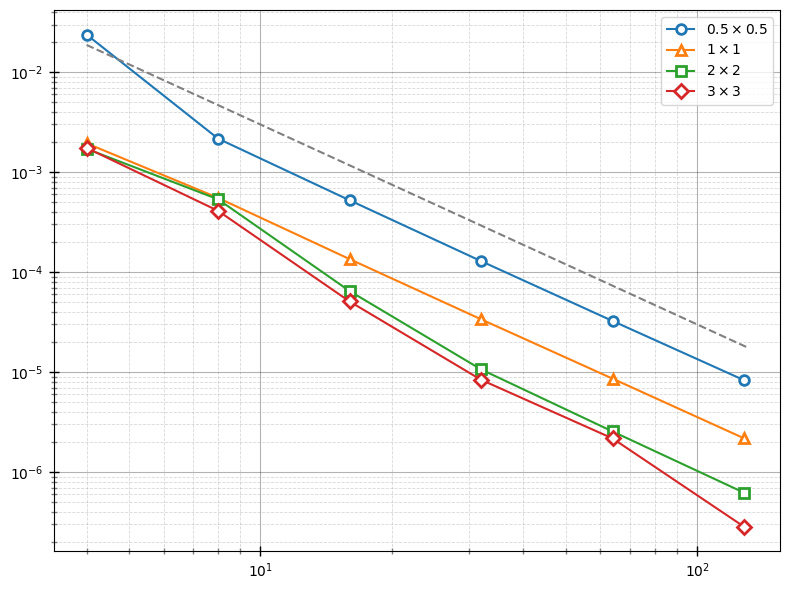

In [23]:
def printL2Norms(vertex_data, pressure_data, parameters):
    grid_density_parameters, mp_per_cell_parameters = parameters

    log_h = [np.log10(h) for h in grid_density_parameters]

    fig, ax = plt.subplots(figsize=(8, 6))
    for i, mp_per_cell in enumerate(mp_per_cell_parameters):
        error_list = all_error[i]
        error_norms_list = all_error_norm[i]

        normed_error = [(error_list[j] / error_norms_list[j]) for j in range(len(error_list))]
        logged_error = [np.log10(norm_error) for norm_error in normed_error]
        res = linregress(log_h[2:], logged_error[2:])
        print(res.slope)
        ax.loglog(grid_density_parameters, normed_error, 
                    marker=markers[mp_per_cell],
                    markersize=7,
                    linestyle='-',
                    color=colors[mp_per_cell],
                    alpha=1.0,
                    markerfacecolor='white',
                    markeredgewidth=2.0,
                    label=f"${mp_per_cell}\\times{mp_per_cell}$")
        
    xfine=np.linspace(4, 130, 1000)
    ax.loglog(xfine, 0.3*np.pow(xfine, -2), color="grey", linestyle="--")
    
    ax.legend()
    ax.grid(True, which='major', linestyle='-', linewidth=0.8, color='black', alpha=0.3)
    ax.grid(True, which='minor', linestyle='--', linewidth=0.6, color='gray', alpha=0.3)
    # ax.set_xlabel("Grid Spacing $h^{-1}$")
    # ax.set_ylabel("L2 Average Error of Radii $\|e\|_2$")
    ax.tick_params(axis='both', which='major', direction='inout', length=7.5, width=1, colors='black')
    ax.tick_params(axis='both', which='minor', direction='inout', length=5, width=1, colors='gray')
    
    fig.tight_layout()
    fig.savefig("../../ex2_radius_convergence.svg")
    fig.show()


printL2Norms(point_data, pressure_data, parameters)

[[np.float64(4.8194902806644835e-06), np.float64(6.504992815560591e-07), np.float64(1.4891601871909034e-07), np.float64(4.2235867101466926e-08), np.float64(1.2343180262681639e-08), np.float64(3.57432959612456e-09)], [np.float64(3.6514738347337925e-06), np.float64(8.723719262413741e-07), np.float64(4.979336218716973e-07), np.float64(2.569648170002546e-07), np.float64(5.5068113480731094e-08), np.float64(2.678855417088088e-08)], [np.float64(3.6539972299523218e-06), np.float64(1.521313296451764e-06), np.float64(7.304521243147809e-07), np.float64(2.929143795193954e-07), np.float64(6.578179016731921e-08), np.float64(2.367218057412056e-08)], [np.float64(4.090836910908972e-06), np.float64(1.7020150563353803e-06), np.float64(7.792268052990985e-07), np.float64(3.213476404681967e-07), np.float64(1.038155476454755e-07), np.float64(4.002471840792422e-08)]]
[[np.float64(6.11893424885665e-05), np.float64(6.393312467489793e-05), np.float64(6.383185152910822e-05), np.float64(6.381424494453609e-05), np.

/tmp/ipykernel_18516/3001042892.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


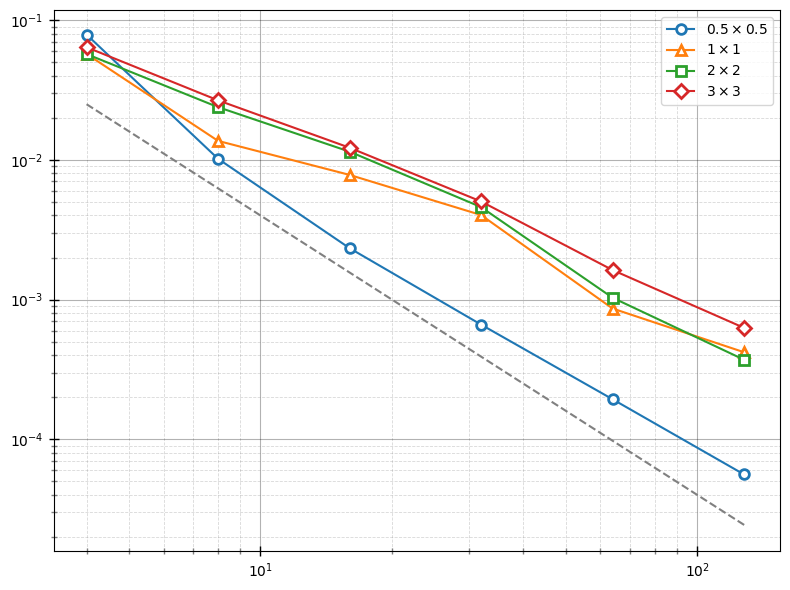

In [25]:
def printL2NormsPressure(pressure_data, parameters):
    grid_density_parameters, mp_per_cell_parameters = parameters

    error_pressure = [[0.0 for x in range(len(grid_density_parameters))] for y in range(len(mp_per_cell_parameters))]
    error_pressure_norm = [[0.0 for x in range(len(grid_density_parameters))] for y in range(len(mp_per_cell_parameters))]
    for i in range(len(mp_per_cell_parameters)):
        for j in range(len(grid_density_parameters)):
            error = 0.0
            error_norm = 0.0
            pressures, volumes = pressure_data[i][j]
            for k in range(len(pressures)):
                p, v = np.array(pressures[k]), np.array(volumes[k])
                error += (p - p_expected)**2 * v
                error_norm += (p)**2 * v

            error_pressure[i][j] = np.sqrt(error)
            error_pressure_norm[i][j] = np.sqrt(error_norm)

    print(error_pressure)
    print(error_pressure_norm)

    log_h = [np.log10(h) for h in grid_density_parameters]

    fig, ax = plt.subplots(figsize=(8, 6))
    for i, mp_per_cell in enumerate(mp_per_cell_parameters):
        error_list = error_pressure[i]
        error_norms_list = error_pressure_norm[i]
        normed_error = [(error_list[j] / error_norms_list[j]) for j in range(len(error_list))]
        logged_error = [np.log10(norm_error) for norm_error in normed_error]
        res = linregress(log_h[-3:], logged_error[-3:])
        print(res.slope)
        ax.loglog(grid_density_parameters, normed_error, 
                    marker=markers[mp_per_cell],
                    markersize=7,
                    linestyle='-',
                    color=colors[mp_per_cell],
                    alpha=1.0,
                    markerfacecolor='white',
                    markeredgewidth=2.0,
                    label=f"${mp_per_cell}\\times{mp_per_cell}$")
        
    xfine=np.linspace(4, 130, 1000)
    ax.loglog(xfine, 0.4*np.pow(xfine, -2), color="grey", linestyle="--")
    ax.legend()
    ax.grid(True, which='major', linestyle='-', linewidth=0.8, color='black', alpha=0.3)
    ax.grid(True, which='minor', linestyle='--', linewidth=0.6, color='gray', alpha=0.3)

    ax.tick_params(axis='both', which='major', direction='inout', length=7.5, width=1, colors='black')
    ax.tick_params(axis='both', which='minor', direction='inout', length=5, width=1, colors='gray')

    fig.tight_layout()
    fig.savefig("../../ex2_pressure_convergence.svg")
    fig.show()


printL2NormsPressure(pressure_data, parameters)